### In this notebook we solve 2D Mixed Elasticity with assmbled/matrix-free approaches. Also inf-sup constant is computed for continuous and discontinuous pressure

In [1]:
using Plots
using LinearAlgebra
using SparseArrays
using FastGaussQuadrature
using NLsolve
using Random
using DataFrames
using Test

In [2]:
default(linewidth=3)
function my_spy(A)
    cmax = norm(vec(A), Inf)
    s = max(1, ceil(30 / size(A, 1)))
    spy(A, marker=(:square, s), c=:diverging_rainbow_bgymr_45_85_c67_n256, clims=(-cmax, cmax))
end

my_spy (generic function with 1 method)

In [3]:
function vander_legendre_deriv(x, k=nothing)
    if isnothing(k)
        k = length(x) # Square matrix by default
    end
    m = length(x)
    Q = ones(m, k)
    dQ = zeros(m, k)
    Q[:, 2] = x
    dQ[:, 2] .= 1
    for n in 1:k-2
        Q[:, n+2] = ((2*n + 1) * x .* Q[:, n+1] - n * Q[:, n]) / (n + 1)
        dQ[:, n+2] = (2*n + 1) * Q[:,n+1] + dQ[:,n]
    end
    Q, dQ
end

function febasis1D(P, Q, Qmode)
    x, _ = gausslobatto(P)
    if Qmode == "GAUSS"
        q, w = gausslegendre(Q)
    elseif Qmode == "GLL"
        q, w = gausslobatto(Q)
    else
        error("Qmode error! Choose GAUSS or GLL Quadrature points!");
    end
    V, _ = vander_legendre_deriv(x)
    Bp, Dp = vander_legendre_deriv(q, P)
    B = Bp / V
    D = Dp / V
    x, q, w, B, D
end

meshgrid(x, y) = (repeat(x, outer=length(y)), repeat(y, inner=length(x)))

function febasis2D(P, Q, num_comp, Qmode)
    # coordinate, quadrature, and basis on reference element [-1,1]
    x1_ref, q1_ref, w1_ref, B1, D1 = febasis1D(P, Q, Qmode)
    
    x, y = meshgrid(x1_ref, x1_ref)
    x2_ref = [x;y]
    qx, qy = meshgrid(q1_ref, q1_ref)
    q2_ref = [qx;qy]
    w2_ref = kron(w1_ref, w1_ref)
    
    B2 = kron(I(num_comp),kron(B1,B1))
    Dx = kron(B1, D1)
    Dy = kron(D1, B1)
    # Grad for num_comp = 1
    Dx = kron([1, 0], Dx)
    Dy = kron([0, 1], Dy)
    D2 = Dx + Dy
    D2 = kron(I(num_comp),D2)
    
    x2_ref, q2_ref, w2_ref, B2, D2
end

struct FEBasis
    P::Int
    Pp::Int
    Q::Int
    num_comp::Int 
    Qmode::String
    x_ref::Vector  # nodes at 2D ref element
    q_ref::Vector  # quad pts for 2D ref element
    w_ref::Vector  # weights for 2D ref element
    B::Matrix  # Interpolation for u
    D::Matrix  # Derivative for u
    Bp::Matrix
    p_is_tensor::Bool
    function FEBasis(P, Pp, Q, num_comp, Qmode, p_is_tensor)
        x_ref, q_ref, w_ref, B, D = febasis2D(P, Q, num_comp, Qmode)
        if !p_is_tensor && Pp == 1 # This is constant P0 discontinuous element
            Bp = ones(Q^2,1)
        elseif !p_is_tensor && Pp == 3 # This is linear P1 discontinuous element
            q_ref2 = reshape(q_ref, Q^2,:);
            Bp = hcat(ones(Q^2), q_ref2[:,1], q_ref2[:,2])
        elseif !p_is_tensor && Pp == 6 # This is quadratic P2 discontinuous element
            q_ref2 = reshape(q_ref, Q^2,:);
            Bp = hcat(ones(Q^2), q_ref2[:,1], q_ref2[:,2], q_ref2[:,1] .* q_ref2[:,2], 
                      q_ref2[:,1] .* q_ref2[:,1], q_ref2[:,2] .* q_ref2[:,2])
        elseif p_is_tensor && Pp > 1 # This is Q element
            _, _, _, Bp, _ = febasis2D(Pp, Q, 1, Qmode)
        else
            error("Unsupported dof for pressure field");
        end
        
        new(P, Pp, Q, num_comp, Qmode, x_ref, q_ref, w_ref, B, D, Bp, p_is_tensor)
    end
end

In [4]:
#define P1 basis on physical element
function P1_basis_phy(q, Q)
    # note q is quadrature pts in elmenet E obtained by q = Bx * Coord_E
    qq = reshape(q, Q^2,:);
    Bp = hcat(ones(Q^2), qq[:,1], qq[:,2])
    return Bp
end

P1_basis_phy (generic function with 1 method)

# Assembled approach
$\sigma = -p I + 2\mu \epsilon_d $, $p=-\kappa \nabla \cdot u $
$$ \int_{\Omega} \nabla v \sigma= \int_{\Omega} v f, \forall v$$
$$ \int_{\Omega} q \left(-\nabla\cdot u - p/\kappa \right)= 0, \forall q$$

In [5]:
function GetConnectivity(P, nx, ny)
    """This function returns the connectivity array

    4-------5--------6
    |       |        |
    |       |        |
    |       |        |
    1-------2--------3
    local numbering of one element is

    3-------4
    |       |
    |       |
    |       |
    1-------2


    Input:
    ------
    nx: number of element in x direction start from 1 NOT 0
    ny: number of element in y direction start from 1 NOT 0
    Output:
    ------
    idx: connectivity index of size (num_elem x P*P) based on above node numbering
    idx_bc: index for 4 faces to apply bc: [bottom, right, top, left]
    """
    n_elems = [nx, ny]
    nodes_u = zeros(Int64, 2)
    nodes_x = zeros(Int64, 2)
    for d=1:2
        nodes_u[d] = n_elems[d]*(P-1) + 1
        nodes_x[d] = n_elems[d]*(2-1) + 1
    end

    num_elem = n_elems[1] * n_elems[2]
    idx_x = zeros(Int64, 4, num_elem) # Coordinate connectivity
    idx_u = zeros(Int64, P * P, num_elem) # Solution connectivity
    for i=1:n_elems[1]
        for j=1:n_elems[2]
            ele = (j-1)*n_elems[1] + i
            for ii=1:P
                for jj=1:P
                    if (ii < 3) && (jj < 3)
                        idx_x[(ii-1) * 2 + jj, ele] = ((j-1) * (2 - 1) + ii-1) * nodes_x[1] + (i-1) * (2 - 1) + jj
                    end
                    idx_u[(ii-1) * P + jj, ele] = ((j-1) * (P - 1) + ii-1) * nodes_u[1] + (i-1) * (P - 1) + jj
                end
            end
        end
    end
    
    idx_b = Int64[] # bottom face
    idx_t = Int64[] # top face
    for i=1:n_elems[1]
        if i==1
            append!(idx_b, idx_u[1:P,i])
            append!(idx_t, idx_u[P*(P-1)+1:P*P,i + n_elems[1]*(n_elems[2] -1)])
        else
            append!(idx_b, idx_u[2:P,i])
            append!(idx_t, idx_u[P*(P-1)+2:P*P,i + n_elems[1]*(n_elems[2] -1)])
        end
    end

    idx_l = Int64[] # left face
    idx_r = Int64[] # right face
    for i=1:n_elems[1]:num_elem
        if i==1
            append!(idx_l, idx_u[1:P:P*(P-1)+1,i])
            append!(idx_r, idx_u[P:P:P*P,i+n_elems[1]-1])
        else
            append!(idx_l, idx_u[P+1:P:P*(P-1)+1,i])
            append!(idx_r, idx_u[2*P:P:P*P,i+n_elems[1]-1])
        end
    end
    
    return idx_x, idx_u, idx_b, idx_r, idx_t, idx_l, nodes_u
end

function GetConnectivityPressure(Pp, nx, ny, p_is_continuous, p_is_tensor)
    """This function returns the connectivity array for pressure field
    """
    n_elems = [nx, ny]
    num_elem = n_elems[1] * n_elems[2]
    
    if !p_is_tensor && !p_is_continuous && Pp == 1
        elem_dof_p = 1 
        idx_p = zeros(Int64, elem_dof_p, num_elem) # Solution connectivity for p
        for i=1:num_elem
            idx_p[1, i] = i
        end
    elseif !p_is_tensor && !p_is_continuous && Pp == 3
        elem_dof_p = 3
        idx_p = zeros(Int64, elem_dof_p, num_elem) # Solution connectivity for p
        k = 0
        for i=1:num_elem
            for j=1:elem_dof_p
                idx_p[j, i] = j + k
            end
            k += elem_dof_p
        end
    elseif !p_is_tensor && !p_is_continuous && Pp == 6
        elem_dof_p = 6
        idx_p = zeros(Int64, elem_dof_p, num_elem) # Solution connectivity for p
        k = 0
        for i=1:num_elem
            for j=1:elem_dof_p
                idx_p[j, i] = j + k
            end
            k += elem_dof_p
        end
    elseif p_is_tensor && !p_is_continuous && Pp > 1
        elem_dof_p = Pp^2
        idx_p = zeros(Int64, elem_dof_p, num_elem) # Solution connectivity for p
        k = 0
        for i=1:num_elem
            for j=1:elem_dof_p
                idx_p[j, i] = j + k
            end
            k += elem_dof_p
        end
    elseif p_is_tensor && p_is_continuous && Pp > 1
        nodes_p = zeros(Int64, 2)
        for d=1:2
            nodes_p[d] = n_elems[d]*(Pp-1) + 1
        end
        idx_p = zeros(Int64, Pp * Pp, num_elem) # Solution connectivity for p
        for i=1:n_elems[1]
            for j=1:n_elems[2]
                ele = (j-1)*n_elems[1] + i
                for ii=1:Pp
                    for jj=1:Pp
                        idx_p[(ii-1) * Pp + jj, ele] = ((j-1) * (Pp - 1) + ii-1) * nodes_p[1] + (i-1) * (Pp - 1) + jj
                    end
                end
            end
        end
    else
        error("Unsupported dof for pressure field");
    end
    
    return idx_p
end

struct FEIndices
    P::Int
    Pp::Int
    nx::Int
    ny::Int
    idx_x::Matrix
    idx_u::Matrix
    idx_p::Matrix
    idx_b::Vector
    idx_r::Vector
    idx_t::Vector
    idx_l::Vector
    nodes_u::Vector
    Er_x::Vector
    Er_u::Vector
    Er_p::Vector
    p_is_continuous::Bool
    p_is_tensor::Bool
    function FEIndices(P, Pp, num_comp, nx, ny, p_is_continuous, p_is_tensor)
        idx_x, idx_u, idx_b, idx_r, idx_t, idx_l, nodes_u = GetConnectivity(P, nx, ny)
        idx_p = GetConnectivityPressure(Pp, nx, ny, p_is_continuous, p_is_tensor)
        # number of nodes
        dof_u = maximum(idx_u)
        dof_p = maximum(idx_p)
        dof_x = maximum(idx_x)
        # element dof
        elem_dof_u = size(idx_u, 1)
        elem_dof_p = size(idx_p, 1)
        elem_dof_x = size(idx_x, 1)
        num_elem = size(idx_x, 2)
        # element restriction operator
        Er_x = []
        Er_u = []
        Er_p = []
        idx_p = idx_p .+ num_comp * dof_u
        for e = 1:num_elem
            Lx = spzeros(Int64, elem_dof_x, dof_x)
            Lu = spzeros(Int64, elem_dof_u, dof_u)
            L = spzeros(Int64, elem_dof_u * num_comp, dof_p)
            Lp = zeros(Int64, elem_dof_p, num_comp*dof_u + dof_p)
            for i=1:elem_dof_u
                if i < elem_dof_x + 1
                    Lx[i, idx_x[i, e] ] = 1
                end
                Lu[i, idx_u[i, e] ] = 1
            end
            
            for i=1:elem_dof_p
                Lp[i, idx_p[i, e] ] = 1
            end
            
            Lx = kron(I(2), Lx)
            Lu = kron(I(num_comp), Lu)
            Lu = hcat(Lu, L)
            push!(Er_x, Lx)
            push!(Er_u, Lu)
            push!(Er_p, Lp)
        end
        
        new(P, Pp, nx, ny, idx_x, idx_u, idx_p, idx_b, idx_r, idx_t, idx_l, nodes_u, Er_x, Er_u, Er_p, p_is_continuous, p_is_tensor)
    end
end

In [6]:
function GetCoordMesh(mesh, nelx, nely, aspect_ratio)
    """ This function returns the physical coordinates of the nodes.
    Input:
    ------
    nelx:   integer
            number of elements in the x direction.
    nely:   integer
            number of elements in the y direction.
    mesh: can be unifrom or nonuniform

    Output:
    -------
    x:      float (1d array)
            the coordinate of the node in the x direction
    y:      float (1d array)
            the coordinate of the node in the y direction
    The geometry we are working on is like the following.
    (for nelx = 2, nely = 2)
    6---------7----------8
    |         |   (3)    |
    |   (2)   |      ----5
    |      ---4-----/    |
    3-----/   |   (1)    |
    |         |      ----2
    |   (0)   |     /
    |     ----1----/
    0----/
    There are 4 elements (numbering in parenthesis), and 9 nodes.
    This function returns x,y as 9x2 array for the above mesh.
    """
    nodex = nelx + 1
    nodey = nely + 1
    numnodes = nodex*nodey
    # interior nodes for random mesh
    interiornodex = nelx - 1
    interiornodey = nely - 1
    interiornodes = interiornodex*interiornodey

    hx = 1/nelx
    hy = 1/(nely*aspect_ratio)
    h = minimum([hx hy])
    
    if (aspect_ratio <1)
        error!("aspect_ratio must be bigger than 1")
    end

    # Divide [0,1] by nodex (mesh in the x direction)
    x0 = LinRange(0, 1, nodex)
    if mesh == "uniform"
        y0 = 0.0*x0 # the bottom geometry line  
        y = zeros(numnodes, 1)
        for i=1:nodex
            # Divide [0,1] by nodey (mesh in the y direction)
            y1 = LinRange(y0[i], 1/aspect_ratio, nodey)
            for j=1:nodey
                y[i + (j-1)*nodex] = y1[j]   # collection of y
            end
        end
        x = zeros(numnodes, 1)
        for i=1:nodey
            for j=1:nodex
                x[j + (i-1)*nodex] = x0[j]   # collection of x
            end
        end

    elseif mesh == "random"
        y0 = 0.0*x0 # the bottom geometry line  
        y = zeros(numnodes, 1)
        for i=1:nodex
            # Divide [0,1] by nodey (mesh in the y direction)
            y1 = LinRange(y0[i], 1/aspect_ratio, nodey)
            for j=1:nodey
                y[i + (j-1)*nodex] = y1[j]   # collection of y
            end
        end
        x = zeros(numnodes, 1)
        for i=1:nodey
            for j=1:nodex
                x[j + (i-1)*nodex] = x0[j]   # collection of x
            end
        end
        Random.seed!(1234)
        randnodes_x = rand(interiornodes,1)*hx/2 .- hx/4
        randnodes_y = rand(interiornodes,1)*hy/2 .- hy/4
        # perturb the (x,y) of interior nodes
        for i=1:interiornodey
            for j=1:interiornodex
                x[i*(nodex) + j+1] = x[i*(nodex) + j+1] - randnodes_x[j+(i-1)*interiornodex]
                y[i*(nodex) + j+1] = y[i*(nodex) + j+1] - randnodes_y[j+(i-1)*interiornodex]
            end
        end
        
    elseif mesh == "trapezoid"
        y0 = 0.0*x0 # the bottom geometry line  
        y = zeros(numnodes, 1)
        for i=1:nodex
            # Divide [0,1] by nodey (mesh in the y direction)
            y1 = LinRange(y0[i], 1, nodey)
            for j=1:nodey
                y[i + (j-1)*nodex] = y1[j]   # collection of y
            end
        end
        x = zeros(numnodes, 1)
        for i=1:nodey
            for j=1:nodex
                x[j + (i-1)*nodex] = x0[j]   # collection of x
            end
        end
        # perturb the (x,y) of interior nodes
        for i=1:interiornodey
            for j=1:interiornodex
                #x[i*(nodex) + j+1] = x[i*(nodex) + j+1] - randnodes[j+(i-1)*interiornodex]
                y[i*(nodex) + j+1] = y[i*(nodex) + j+1] - (-1)^j *(h/4)
            end
        end

    else
        error("Enter one of the mesh option: 'unifrom', 'trapezoid', 'random' ")
    end
    
    #
    return x, y

end

function plotmesh(mesh, xc, yc, idx_x)

    p = plot()
    nodes = [1 2 4 3 1]
    xx = zeros(5,1)
    yy = zeros(5,1)
    num_elem = size(idx_x, 2)
    for i = 1:num_elem
        for j =1:5
        xx[j] = xc[idx_x[nodes[j],i]] 
        yy[j] = yc[idx_x[nodes[j],i]] 
        end
        plot!(p,xx,yy,color="black",legend=false)
    end
    
    return p
end

function GetCoordElem(xc, yc, Er_x, e)
    """
    This functions returns coordinate of element "E"
    Input:
    x,y,z: coordinate of all nodes of a mesh
    IENn: connectivity of nodes
    
    Return:
    coord_E: coordinate of element e as a (8,1) array
    which is [x;y] coordinates of the 4 nodes
    """
    
    return Er_x[e]*[xc; yc]
end

GetCoordElem (generic function with 1 method)

In [7]:
function GetQdata(Coord_E, Bx::FEBasis)
    J1 = Bx.D*Coord_E
    J2 = reshape(J1, Bx.Q^2, :)
    J = zeros(Bx.Q^2, 2, 2)
    detJ = zeros(Bx.Q^2)
    dXdx_T = zeros(Bx.Q^2, 2, 2)
    for i=1:Bx.Q^2
        J[i,:,:] = reshape(J2[i,:], 2, 2)
        detJ[i] = det(J[i,:,:])
        dXdx_T[i,:,:] = I/J[i,:,:]
    end
    
    # quadrature pts in elmenet E
    q = Bx.B * Coord_E
    
    wdetJ = Bx.w_ref .* detJ;
    
    return q, wdetJ, dXdx_T
end

function GetRhsLocal(kappa, mu, wdetJ, q, f, Bu::FEBasis)
    
    Wu = diagm([wdetJ; wdetJ])
    xq = reshape(q, Bu.Q^2,:)
    Feu = Bu.B' * Wu * f(kappa, mu, xq[:,1], xq[:,2])  # v^T * f
    Fep = zeros(size(Bu.Bp,2))
    return Feu, Fep
end

function GetLocalOperator(kappa, mu, wdetJ, dXdx_T, Bu::FEBasis)
    
    Wp = diagm(wdetJ)
    Ws = diagm([wdetJ; wdetJ; wdetJ; wdetJ]);
    
    # sigma = -p I + 2 mu ed; where, ed = e - 1/3 * trace(e) * I, I know it should be 1/2 beacuse is 2D, anyway ...
    # e = 0.5*(grad_u + grad_u^T)
    grad_v = zeros(2 * Bu.num_comp * Bu.Q^2, size(Bu.D,2))
    div_v = zeros(2 * Bu.num_comp * Bu.Q^2, size(Bu.Bp,2))
    q_div = zeros(Bu.Q^2, size(Bu.D,2))
    qp  = zeros(Bu.Q^2, size(Bu.Bp,2))
    for i=1:Bu.Q^2
        D1 = zeros(2, size(Bu.D,2))
        D1[1,:] = Bu.D[i,:]
        D1[2,:] = Bu.D[i + Bu.Q^2,:]
        grad_u1 = dXdx_T[i,:,:] * D1
        D2 = zeros(2, size(Bu.D,2))
        D2[1,:] = Bu.D[i + 2*Bu.Q^2,:]
        D2[2,:] = Bu.D[i + 3*Bu.Q^2,:]
        grad_u2 = dXdx_T[i,:,:] * D2
        # tr(e) = div(u)
        tr_e = grad_u1[1,:] + grad_u2[2,:]
        # ed = e - 1/3 * trace(e) * I
        ed11 = grad_u1[1,:] - 1/3. * tr_e
        ed12 = (grad_u1[2,:] + grad_u2[1,:]) / 2.
        ed22 = grad_u2[2,:] - 1/3. * tr_e
        Ed1 = dXdx_T[i,:,:]' * vcat(ed11', ed12')
        Ed2 = dXdx_T[i,:,:]' * vcat(ed12', ed22')

        p1 = Bu.Bp[i,:]
        p12 = 0. * Bu.Bp[i,:]
        P1 = dXdx_T[i,:,:]' * vcat(p1', p12')
        P2 = dXdx_T[i,:,:]' * vcat(p12', p1')
        # 2 mu (grad(v), e)
        grad_v[i,:] = 2 * mu * Ed1[1,:]
        grad_v[i + Bu.Q^2,:] = 2 * mu * Ed1[2,:]
        grad_v[i + 2*Bu.Q^2,:] = 2 * mu * Ed2[1,:]
        grad_v[i + 3*Bu.Q^2,:] = 2 * mu * Ed2[2,:]
        # -(div(v), p)
        div_v[i,:] = -P1[1,:]
        div_v[i + Bu.Q^2,:] = -P1[2,:]
        div_v[i + 2*Bu.Q^2,:] = -P2[1,:]
        div_v[i + 3*Bu.Q^2,:] = -P2[2,:]
        # -(q, div(u))
        q_div[i, :] = -tr_e
        # -(q, p)/kappa
        qp[i,:] = -Bu.Bp[i,:] / kappa
        
    end
    
    Ke11 = Bu.D' * Ws * grad_v
    Ke12 = Bu.D' * Ws * div_v
    Ke21 = Bu.Bp' * Wp * q_div
    Ke22 = Bu.Bp' * Wp * qp
    
    return Ke11, Ke12, Ke21, Ke22
end

function GetDirichletBCsIndex(num_comp, Ind::FEIndices)
    num_nodes = Ind.nodes_u[1] * Ind.nodes_u[2]
    bc_idx = Int64[]
    for c=0:num_comp -1
        # bottom
        for i=1:Ind.nodes_u[1]
            append!(bc_idx, Ind.idx_b[i] .+ c * num_nodes)
        end
        # right
        for j=2:Ind.nodes_u[2]-1
            append!(bc_idx, Ind.idx_r[j] .+ c * num_nodes)
        end
        # top
        for i=1:Ind.nodes_u[1]
            append!(bc_idx, Ind.idx_t[i] .+ c * num_nodes)
        end
        # left
        for j=2:Ind.nodes_u[2]-1
            append!(bc_idx, Ind.idx_l[j] .+ c * num_nodes)
        end
    end
    
    return bc_idx
end

function GetNodalCoordinate(xc, yc, Q, Ind::FEIndices)
    """
    return x for plotting the results in 2D
    """
    num_elem = size(Ind.idx_u,2)
    global_dof = maximum(Ind.idx_p);
    global_dof_u = 2 * maximum(Ind.idx_u);
    global_dof_p = global_dof - global_dof_u;
    
    _, _, _, BL, _ = febasis2D(2, Q, 2, "GLL");
    xu = spzeros(global_dof, 1)
    mult_u = spzeros(global_dof, 1)
    for e=1:num_elem
        # Get coordinate of each element
        Coord_E = GetCoordElem(xc, yc, Ind.Er_x, e);
        xe = BL * Coord_E
        xu = xu + Ind.Er_u[e]' * xe
        mult_u += Ind.Er_u[e]' * Ind.Er_u[e] * ones(global_dof)
    end
    xu = xu ./ mult_u
    xu[1:global_dof_u]
end

function GetFEMixed(kappa, mu, xc, yc, Ind::FEIndices, Bx::FEBasis, Bu::FEBasis, f, bc_idx, u_bc)

    num_elem = size(Ind.idx_u,2)
    global_dof = maximum(Ind.idx_p)
    global_dof_u = 2 * maximum(Ind.idx_u)
    F = spzeros(global_dof, 1)
    K = spzeros(global_dof, global_dof)
    
    for e=1:num_elem
        # Get coordinate of each element
        Coord_E = GetCoordElem(xc, yc, Ind.Er_x, e);
        # Update quadrature
        q, wdetJ, dXdx = GetQdata(Coord_E, Bx);
        
        Ke11, Ke12, Ke21, Ke22 = GetLocalOperator(kappa, mu, wdetJ, dXdx, Bu)
        Feu, Fep = GetRhsLocal(kappa, mu, wdetJ, q, f, Bu);  # v^T * f

        # Assemble
        K = K + Ind.Er_u[e]' * Ke11 * Ind.Er_u[e] + Ind.Er_u[e]' * Ke12 * Ind.Er_p[e] +
                Ind.Er_p[e]' * Ke21 * Ind.Er_u[e] + Ind.Er_p[e]' * Ke22 * Ind.Er_p[e];
        F = F + Ind.Er_u[e]' * Feu + Ind.Er_p[e]' * Fep

    end
    
    F[bc_idx].= u_bc
    K[bc_idx,:] .= 0.; #K[:, bc_idx] .= 0.
    for i=1:length(bc_idx)
        K[bc_idx[i], bc_idx[i]] = 1.
    end
    # U=[u, p]
    U = K \ F
    
   return U
end

function GetL2Error(kappa, xc, yc, Ind::FEIndices, Bx::FEBasis, Bu::FEBasis, Uh, uex, pex)
    """This function returns L2 error 
    (sum_{e=1:num_elem} (int_e (uh - uex)^2 dx) )^0.5 
    """

    num_elem = size(Ind.idx_u,2)

    e_u = zeros(num_elem)
    e_p = zeros(num_elem)
    for e=1:num_elem
        # Get coordinate of each element
        Coord_E = GetCoordElem(xc, yc, Ind.Er_x, e);
        # Update quadrature
        q, wdetJ, _ = GetQdata(Coord_E, Bx);
        
        wdetJu = [wdetJ; wdetJ]
        
        # dh and ph are the nodal values for u and p for element e
        dh = Ind.Er_u[e] * Uh
        ph = Ind.Er_p[e] * Uh
        # Compute uh(x) and ph(x) in quadrature x=q in L2 space 
        u_num = Bu.B * dh
        p_num = Bu.Bp * ph
        
        xq = reshape(q, Q^2,:)
        u_ex = uex(xq[:,1], xq[:,2])
        p_ex = pex(kappa, xq[:,1], xq[:,2])

        err_u = vec((u_num - u_ex))
        err_p = vec((p_num - p_ex))
        # \int (u_num - u_ex)^2 dx ==> on element e
        e_u[e] = wdetJu' * (err_u .* err_u)
        e_p[e] = wdetJ' * (err_p .* err_p)

    end

    return sqrt(sum(e_u)), sqrt(sum(e_p))
end
    
function GetL2ErrorDisc(kappa, xc, yc, Ind::FEIndices, Bx::FEBasis, Bu::FEBasis, Uh, uex, pex)
    """This function returns L2 error 
    (sum_{e=1:num_elem} (int_e (uh - uex)^2 dx) )^0.5 
    """

    num_elem = size(Ind.idx_u,2)
    global_dof = maximum(Ind.idx_p)
    global_dof_u = Bu.num_comp * maximum(Ind.idx_u)
        
    e_U = zeros(global_dof)
        
    for e=1:num_elem
        # Get coordinate of each element
        Coord_E = GetCoordElem(xc, yc, Ind.Er_x, e);
        # Update quadrature
        q, wdetJ = GetQdata(Coord_E, Bx);

        # dh and ph are the nodal values for u and p for element e
        dh = Ind.Er_u[e] * Uh
        ph = Ind.Er_p[e] * Uh
        # Compute uh(x) and ph(x) in quadrature x=q in L2 space 
        u_num = Bu.B * dh
        p_num = Bu.Bp * ph
        
        xq = reshape(q, Q^2,:)
        u_ex = uex(xq[:,1], xq[:,2])
        p_ex = pex(kappa, xq[:,1], xq[:,2])

        err_u = vec((u_num - u_ex))
        err_p = vec((p_num - p_ex))
            
        Wu = diagm([wdetJ; wdetJ])
        Wp = diagm(wdetJ)
        er1 = Bu.B' * Wu * (err_u .* err_u)
        er2 = Bu.Bp' * Wp * (err_p .* err_p)
        
        e_U = e_U + Ind.Er_u[e]' * er1 + Ind.Er_p[e]' * er2

    end
        

    return sqrt(sum(e_U[1:global_dof_u])), sqrt(sum(e_U[global_dof_u+1:end]))
end

GetL2ErrorDisc (generic function with 1 method)

# Inf-Sup test
To get the inf-sup cosntant we need to solve (see eq (3.2) of Arnold and Marie 2009)

$$
<u,v>_V + b(v,p) + b(u,q) = -\lambda <p,q>_Q \quad \text{for all} \quad v,q \in V\times Q
$$
Then, the inf-sup constant, $\beta$ is
$$
\beta = \sqrt{\lambda_{min}}
$$

We can create

$$
\begin{bmatrix} \boldsymbol H &\boldsymbol B^T\\\boldsymbol B& \boldsymbol 0 \end{bmatrix} \begin{bmatrix}\boldsymbol U\\ \boldsymbol P \end{bmatrix}=  -\lambda \begin{bmatrix} \boldsymbol 0 & \boldsymbol 0\\ \boldsymbol 0 &\boldsymbol C \end{bmatrix}  \begin{bmatrix}\boldsymbol U\\ \boldsymbol P \end{bmatrix}
$$

where $\boldsymbol H = <\boldsymbol u,\boldsymbol v>,\boldsymbol B = b(\boldsymbol u,q), \boldsymbol B^T = b(\boldsymbol v,p), \boldsymbol C = <p,q>$.

By solving above equation
$$
\boldsymbol H \boldsymbol U = -\boldsymbol B^T \boldsymbol P , \\
\boldsymbol B \boldsymbol U = -\lambda \boldsymbol C \boldsymbol P
$$
from the first equation we get $\boldsymbol U = -\boldsymbol H^{-1} \boldsymbol B^T \boldsymbol P$ and replace it in second equation gives
$$
(\boldsymbol B \boldsymbol H^{-1} \boldsymbol{B}^T ) \boldsymbol P = \lambda \boldsymbol C \boldsymbol P
$$

$\sqrt{\lambda_{min}}$ in above equation is infsup constant.
$$
\boldsymbol H =<\boldsymbol v,\boldsymbol u>_{H1}= \int \boldsymbol v \boldsymbol u + \int \nabla\boldsymbol v \nabla \boldsymbol u,\\
\boldsymbol C = <p,q>_{L^2} = \int pq
$$

To find coercivity constant we solve

$$
a(u,v) + b(v,p) + b(u,q) = \lambda <u,v>_V \quad \text{for all} \quad v,q \in V\times Q
$$
Then, the coercivity constant, $\alpha$ is
$$
\alpha = \min{|\lambda_{min}|}
$$

In [8]:
function GetInfSupLocalOperator(q, wdetJ, dXdx_T, Bu::FEBasis, P1_config)
    
    Wp = diagm(wdetJ)
    Wm = diagm([wdetJ; wdetJ]);
    Ws = diagm([wdetJ; wdetJ; wdetJ; wdetJ]);
    
    if P1_config == "physical"
        basis_p = P1_basis_phy(q, Bu.Q)
    else
        basis_p = Bu.Bp
    end
    grad_v = zeros(2 * Bu.num_comp * Bu.Q^2, size(Bu.D,2))
    div_v = zeros(2 * Bu.num_comp * Bu.Q^2, size(Bu.Bp,2))
    q_div = zeros(Bu.Q^2, size(Bu.D,2))
    qp  = zeros(Bu.Q^2, size(basis_p, 2))
    for i=1:Bu.Q^2
        D1 = zeros(2, size(Bu.D,2));
        D1[1,:] = Bu.D[i,:]
        D1[2,:] = Bu.D[i + Bu.Q^2,:]
        grad_u1 = dXdx_T[i,:,:] * D1
        D2 = zeros(2, size(Bu.D,2));
        D2[1,:] = Bu.D[i + 2*Bu.Q^2,:]
        D2[2,:] = Bu.D[i + 3*Bu.Q^2,:]
        grad_u2 = dXdx_T[i,:,:] * D2
        # tr(e) = div(u)
        tr_e = grad_u1[1,:] + grad_u2[2,:]
        G1 = dXdx_T[i,:,:]' * grad_u1
        G2 = dXdx_T[i,:,:]' * grad_u2

        # (grad(v), grad(u))
        grad_v[i,:] = G1[1,:]
        grad_v[i + Bu.Q^2,:] = G1[2,:]
        grad_v[i + 2*Bu.Q^2,:] = G2[1,:]
        grad_v[i + 3*Bu.Q^2,:] = G2[2,:]
        # B = (q, div(u))
        q_div[i, :] = tr_e
        # C = (q, p)
        qp[i,:] = basis_p[i,:]
        
    end
    # <v,u>_H1
    He = Bu.B' * Wm * Bu.B + Bu.D' * Ws * grad_v
    # b(u, q)
    Be = basis_p' * Wp * q_div
    # <p,q>_L2
    Ce = basis_p' * Wp * qp
    
    return He, Be, Ce
end


function GetInfSup(xc, yc, Ind::FEIndices, Bx::FEBasis, Bu::FEBasis, P1_config)

    num_elem = size(Ind.idx_u,2)
    global_dof = maximum(Ind.idx_p)
    global_dof_u = 2 * maximum(Ind.idx_u)
    
    K1 = spzeros(global_dof, global_dof)
    
    for e=1:num_elem
        # Get coordinate of each element
        Coord_E = GetCoordElem(xc, yc, Ind.Er_x, e);
        # Update quadrature
        q, wdetJ, dXdx_T = GetQdata(Coord_E, Bx);
        
        He, Be, Ce = GetInfSupLocalOperator(q, wdetJ, dXdx_T, Bu, P1_config)

        # Assemble
        K1 = K1 + Ind.Er_u[e]' * He * Ind.Er_u[e] +
                Ind.Er_p[e]' * Be * Ind.Er_u[e] + Ind.Er_p[e]' * Ce * Ind.Er_p[e];

    end
    
    H = K1[1:global_dof_u,1:global_dof_u];
    C = K1[global_dof_u + 1:end, global_dof_u + 1:end]
    B = K1[global_dof_u + 1:end, 1:global_dof_u]
    
    LHS1 = B * (H \ I) * B'
    RHS1 = C
    D = eigvals(LHS1, RHS1)
    D = real(D)
    lambda1_min = minimum(D) 
    # inf-sup constant
    beta = sqrt(lambda1_min)
     
   return beta
end

GetInfSup (generic function with 1 method)

In [9]:
# P is number of nodes in 1D, P=2 means Q1 element
# Pp is number of nodes in 1D if the pressure is tensor basis, otherwise is number of nodes in 2D
P, Pp, Qmode, p_is_continuous, p_is_tensor = 3, 2, "GAUSS", true, true
Q, num_comp = P, 2
Bx = FEBasis(2, Pp, Q, 2, Qmode, p_is_tensor);
Bu = FEBasis(P, Pp, Q, num_comp, Qmode, p_is_tensor);
nx, ny, mesh, aspect_ratio= 4, 4, "uniform", 1
xc, yc = GetCoordMesh(mesh, nx, ny, aspect_ratio);
Ind = FEIndices(P, Pp, num_comp, nx, ny, p_is_continuous, p_is_tensor);
lambda, mu = 3, 1;
kappa = lambda + 2*mu/3;

function uex(x, y)
    A0 = 1e-3
    s = pi*2
    x0 = pi/2
    y0 = x0
    ux = @. A0 * sin(s*x - x0) * sin(s*y - y0)
    uy = @. 2*ux 
    
    return [ux; uy]
end

function pex(kappa, x, y)
    A0 = 1e-3
    s = pi*2
    x0 = pi/2
    y0 = x0
    ux_x = @. A0 * s * cos(s*x - x0) * sin(s*y - y0)
    ux_y = @. A0 * s * sin(s*x - x0) * cos(s*y - y0)
    uy_y = @. 2 * ux_y
    
    p = @. -kappa * (ux_x + uy_y)
    return p
end

function f(kappa, mu, x, y)
    A0 = 1e-3
    s = pi*2
    x0 = pi/2
    y0 = x0
    ux = @. A0 * sin(s*x - x0) * sin(s*y - y0)
    uy = @. 2*ux 
    
    ux_xx = @. -s^2 * ux
    ux_yy = @. -s^2 * ux
    uy_xx = @. 2 * ux_xx
    uy_yy = @. 2 * ux_yy
    ux_xy = @. A0 * s^2 * cos(s*x - x0) * cos(s*y - y0)
    uy_yx = @. 2 * ux_xy
    
    fx = @. -mu * (ux_xx + ux_yy) - (mu/3 + kappa) * (ux_xx + uy_yx)
    fy = @. -mu * (uy_xx + uy_yy) - (mu/3 + kappa) * (ux_xy + uy_yy) 
    return [fx; fy]
end


# Dirichlet BCs
bc_idx = GetDirichletBCsIndex(Bu.num_comp, Ind);
x = GetNodalCoordinate(xc, yc, Bu.Q, Ind);
x_bc = x[bc_idx]
x_bc = reshape(x_bc,:,2)
u_bc = uex(x_bc[:,1], x_bc[:,2])

uh = GetFEMixed(kappa, mu, xc, yc, Ind, Bx, Bu, f, bc_idx, u_bc);
L2_error_u, L2_error_p = GetL2Error(kappa, xc, yc, Ind, Bx, Bu, uh, uex, pex);
P1_config = ""
beta = GetInfSup(xc, yc, Ind, Bx, Bu, P1_config);
@show L2_error_u, L2_error_p, beta

(L2_error_u, L2_error_p, beta) = (9.466582004640185e-5, 0.004167826125253, 0.9626665946369111)


(9.466582004640185e-5, 0.004167826125253, 0.9626665946369111)

In [10]:
L2_error_u, L2_error_p = GetL2ErrorDisc(kappa, xc, yc, Ind, Bx, Bu, uh, uex, pex);
@show L2_error_u, L2_error_p

(L2_error_u, L2_error_p) = (9.466582004640185e-5, 0.004167826125253)


(9.466582004640185e-5, 0.004167826125253)

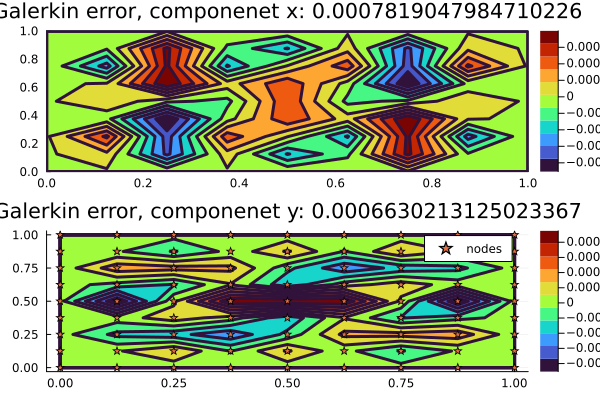

In [11]:
xx = reshape(x, :,2)
err = uh[1:length(x)] - uex(xx[:,1], xx[:,2])
ee = reshape(err, :, 2)
ex = reshape(ee[:,1], Ind.nodes_u[1], Ind.nodes_u[2]) 
ey = reshape(ee[:,2], Ind.nodes_u[1], Ind.nodes_u[2]) 
x1 = reshape(xx[:,1], Ind.nodes_u[1], Ind.nodes_u[2]) 
x2 = reshape(xx[:,2], Ind.nodes_u[1], Ind.nodes_u[2]) 
p1=contourf(x1[:,1], x2[1,:], ex', color=:turbo, levels=10, title="Galerkin error, componenet x: $(norm(ee[:,1]))");
p2=contourf(x1[:,1], x2[1,:], ey', color=:turbo, levels=10, title="Galerkin error, componenet y: $(norm(ee[:,2]))");
scatter!(xx[:,1], xx[:,2], marker=:star, label = "nodes")
plot(p1,p2, layout=(2,1))

# <font color='red'> Matrix-Free approach

In [12]:
# This is like libCEED/Ratel Residual Qfunction
function Compute_f0(kappa, mu, Q, num_comp, wdetJ, q, uq, pq, f)
    
    Wu = diagm([wdetJ; wdetJ])
    xq = reshape(q, Q^2,:)

    Wu * (uq - f(kappa, mu, xq[:,1], xq[:,2]))
end

function Compute_f1g0(kappa, mu, Q, num_comp, wdetJ, dXdx_T, q, Duq, pq)
    
    Wp = diagm(wdetJ)
    Ws = diagm([wdetJ; wdetJ; wdetJ; wdetJ]);
    
    # sigma = -p I + 2 mu ed; where, ed = e - 1/3 * trace(e) * I, e = 0.5*(grad_u + grad_u^T)
    s = zeros(2 * num_comp * Q^2)
    p1  = zeros(Q^2)
    for i=1:Q^2
        grad_u1 = dXdx_T[i,:,:] * [Duq[i], Duq[i + Q^2]]
        grad_u2 = dXdx_T[i,:,:] * [Duq[i + 2*Q^2], Duq[i + 3*Q^2]]
        tr_e = grad_u1[1] + grad_u2[2]
        # ed = e - 1/3 * trace(e) * I
        ed11 = grad_u1[1] - 1/3. * tr_e
        ed12 = (grad_u1[2] + grad_u2[1]) / 2.
        ed22 = grad_u2[2] - 1/3. * tr_e
        # -p I + 2 mu ed
        s11 = 2 * mu * ed11 - pq[i]
        s12 = 2 * mu * ed12
        s22 = 2 * mu * ed22 - pq[i]
        S1 = dXdx_T[i,:,:]' * vcat(s11', s12')
        S2 = dXdx_T[i,:,:]' * vcat(s12', s22')
        
        s[i] = S1[1]
        s[i + Q^2] = S1[2]
        s[i + 2*Q^2] = S2[1]
        s[i + 3*Q^2] = S2[2]
        
        # -(q, div(u)) -(q, p)/kappa
        p1[i] = -tr_e - pq[i] / kappa
        
    end
    # this is actually is f1, and g0
    Ws * s, Wp * p1

end

# This is like libCEED/Ratel Residual Qfunction
function Compute_df0(kappa, mu, Q, num_comp, wdetJ, q, uq, pq, du, dp, f)

    Wu = diagm([wdetJ; wdetJ])
    xq = reshape(q, Q^2,:)

    Wu * du
end

function Compute_df1dg0(kappa, mu, Q, num_comp, wdetJ, dXdx_T, q, Duq, pq, Ddu, dp)
    
    Wp = diagm(wdetJ)
    Ws = diagm([wdetJ; wdetJ; wdetJ; wdetJ]);
    
    ds = zeros(2 * num_comp * Q^2)
    dp1  = zeros(Q^2)
    for i=1:Q^2
        grad_du1 = dXdx_T[i,:,:] * [Ddu[i], Ddu[i + Q^2]]
        grad_du2 = dXdx_T[i,:,:] * [Ddu[i + 2*Q^2], Ddu[i + 3*Q^2]]
        tr_de = grad_du1[1] + grad_du2[2]
        # ded = de - 1/3 * trace(de) * I
        ded11 = grad_du1[1] - 1/3. * tr_de
        ded12 = (grad_du1[2] + grad_du2[1]) / 2.
        ded22 = grad_du2[2] - 1/3. * tr_de
        # -dp I + 2 mu ded
        ds11 = 2 * mu * ded11 - dp[i]
        ds12 = 2 * mu * ded12
        ds22 = 2 * mu * ded22 - dp[i]
        dS1 = dXdx_T[i,:,:]' * vcat(ds11', ds12')
        dS2 = dXdx_T[i,:,:]' * vcat(ds12', ds22')
        
        ds[i] = dS1[1]
        ds[i + Q^2] = dS1[2]
        ds[i + 2*Q^2] = dS2[1]
        ds[i + 3*Q^2] = dS2[2]
        
        # -(q, div(du)) -(q, dp)/kappa
        dp1[i] = -tr_de - dp[i] / kappa
        
    end
    
    Ws * ds, Wp * dp1

end

Compute_df1dg0 (generic function with 1 method)

In [13]:
function MixedElasticityResidual(kappa, mu, u_in, xc, yc, Ind::FEIndices, Bx::FEBasis, Bu::FEBasis, f, bc_idx, u_bc)

    u = copy(u_in); v = zero(u)
    u[bc_idx] .= u_bc
    
    num_elem = size(Ind.idx_u,2)
    
    for e=1:num_elem
        # Get coordinate of each element
        Coord_E = GetCoordElem(xc, yc, Ind.Er_x, e);
        # Update quadrature
        q, wdetJ, dXdx_T = GetQdata(Coord_E, Bx);
        
        ue = Ind.Er_u[e] * u
        pe = Ind.Er_p[e] * u
        uq = 0 * Bu.B * ue
        pq = Bu.Bp * pe
        Duq = Bu.D * ue
        
        f0 = Compute_f0(kappa, mu, Bu.Q, Bu.num_comp, wdetJ, q, uq, pq, f);
        f1, g0 = Compute_f1g0(kappa, mu, Bu.Q, Bu.num_comp, wdetJ, dXdx_T, q, Duq, pq);

        ve = Bu.B' * f0 + Bu.D' * f1 # residual of the first equation (u)
        qe = Bu.Bp' * g0             # residual of the first equation (p)
        v += sparse(Ind.Er_u[e]') * ve + sparse(Ind.Er_p[e]') * qe
    end   
    v[bc_idx] = u_in[bc_idx] - u[bc_idx]
    v

end


function MixedElasticityJacobian(kappa, mu, u_in, xc, yc, Ind::FEIndices, Bx::FEBasis, Bu::FEBasis, f, bc_idx, u_bc)

    u = copy(u_in);
    u[bc_idx] .= u_bc
    
    global_dof_u = Bu.num_comp * maximum(Ind.idx_u)
    
    num_elem = size(Ind.idx_u, 2)
    rows, cols, vals = Int[], Int[], Float64[]
    # size of the element
    size_u = Bu.num_comp * Bu.P * Bu.P
    if Ind.p_is_tensor
        size_p = Bu.Pp * Bu.Pp
    else
        size_p = Bu.Pp
    end
    for e=1:num_elem
        # Get coordinate of each element
        Coord_E = GetCoordElem(xc, yc, Ind.Er_x, e);
        # Update quadrature
        q, wdetJ, dXdx_T = GetQdata(Coord_E, Bx);
        ue = Ind.Er_u[e] * u
        pe = Ind.Er_p[e] * u
        Duq = Bu.D * ue
        pq = Bu.Bp * pe
        Jac = zeros(size_u + size_p, size_u + size_p);
        for c=0:Bu.num_comp-1
            for j=1:Bu.P * Bu.P
                Ddu = Bu.D[:,j + c*Bu.P * Bu.P]
                dp = 0 * Bu.Bp[:,1]
                df1, dg0 = Compute_df1dg0(kappa, mu, Q, num_comp, wdetJ, dXdx_T, q, Duq, pq, Ddu, dp)
                Jac[1:size_u,j + c*Bu.P * Bu.P] = Bu.D' * df1
                Jac[size_u + 1:end,j + c*Bu.P * Bu.P] = Bu.Bp' * dg0
            end
        end
        for j=1:size_p
            Ddu = 0*Bu.D[:,1]
            dp = Bu.Bp[:,j]
            df1, dg0 = Compute_df1dg0(kappa, mu, Q, num_comp, wdetJ, dXdx_T, q, Duq, pq, Ddu, dp)
            Jac[1:size_u, j + size_u] = Bu.D' * df1
            Jac[size_u + 1:end, j + size_u] = Bu.Bp' * dg0
        end
        inds = rowvals(sparse(Ind.Er_u[e]'))
        append!(inds, rowvals(sparse(Ind.Er_p[e]')))
        append!(rows, kron(ones(size_u + size_p), inds))
        append!(cols, kron(inds, ones(size_u + size_p)))
        append!(vals, vec(Jac))
    end   
    A = sparse(rows, cols, vals)
    A[bc_idx,:] .= 0.; A[:, bc_idx] .= 0.
    for i=1:length(bc_idx)
        A[bc_idx[i], bc_idx[i]] = 1.
    end
    A

end

MixedElasticityJacobian (generic function with 1 method)

In [14]:
global_dof = maximum(Ind.idx_p)
u0 = zeros(global_dof);

# Dirichlet BCs
bc_idx = GetDirichletBCsIndex(Bu.num_comp, Ind);
x = GetNodalCoordinate(xc, yc, Bu.Q, Ind);
x_bc = x[bc_idx]
x_bc = reshape(x_bc,:,2)
u_bc = uex(x_bc[:,1], x_bc[:,2])

uh = nlsolve(u -> MixedElasticityResidual(kappa, mu, u, xc, yc, Ind, Bx, Bu, f, bc_idx, u_bc),
             u -> MixedElasticityJacobian(kappa, mu, u, xc, yc, Ind, Bx, Bu, f, bc_idx, u_bc), u0; method = :newton)
L2_error_u, L2_error_p = GetL2Error(kappa, xc, yc, Ind, Bx, Bu, uh.zero, uex, pex)

(9.466582004640179e-5, 0.004167826125253)

# <font color='blue'> Convergence study (Matrix-Free)

In [15]:
# P is number of nodes in 1D, P=2 means Q1 element
# Pp is number of nodes in 1D if the pressure is tensor basis, otherwise is number of nodes in 2D
P, Pp, Qmode, p_is_continuous, p_is_tensor = 4, 6, "GAUSS", false, false
Q, num_comp = P, 2
Bx = FEBasis(2, Pp, Q, 2, Qmode, p_is_tensor);
Bu = FEBasis(P, Pp, Q, num_comp, Qmode, p_is_tensor);
nx, ny, mesh, aspect_ratio= 2, 1, "uniform", 1
xc, yc = GetCoordMesh(mesh, nx, ny, aspect_ratio);
Ind = FEIndices(P, Pp, num_comp, nx, ny, p_is_continuous, p_is_tensor);
lambda, mu = 3e0, 1;
kappa = lambda + 2*mu/3;

nu = 0.5*lambda/(lambda + mu)
E = 2*mu*(1+nu)
@show nu, E

(nu, E) = (0.375, 2.75)


(0.375, 2.75)

In [16]:
res = [4, 8, 12, 16] # elements/side
N = length(res)
eu = zeros(N)
ep = zeros(N)
order_u = []
append!(order_u, 0)
order_p = []
append!(order_p, 0)
H = zeros(N)
# refinement to plot convergence order
for i=1:N

    nx = res[i]
    ny = res[i]

    xc, yc = GetCoordMesh(mesh, nx, ny, aspect_ratio);
    Ind = FEIndices(P, Pp, num_comp, nx, ny, p_is_continuous, p_is_tensor);
    # Dirichlet BCs
    bc_idx = GetDirichletBCsIndex(Bu.num_comp, Ind);
    x = GetNodalCoordinate(xc, yc, Bu.Q, Ind);
    x_bc = x[bc_idx]
    x_bc = reshape(x_bc,:,2)
    u_bc = uex(x_bc[:,1], x_bc[:,2])
    
    global_dof = maximum(Ind.idx_p)
    u0 = zeros(global_dof);
    Uh = nlsolve(u -> MixedElasticityResidual(kappa, mu, u, xc, yc, Ind, Bx, Bu, f, bc_idx, u_bc),
                 u -> MixedElasticityJacobian(kappa, mu, u, xc, yc, Ind, Bx, Bu, f, bc_idx, u_bc), u0; method = :newton)
    L2_error_u, L2_error_p = GetL2ErrorDisc(kappa, xc, yc, Ind, Bx, Bu, Uh.zero, uex, pex)
    
    eu[i] = L2_error_u
    ep[i] = L2_error_p
        
    #h = Gethsz(xc, yc, IEN)
    H[i] = 1/nx

    if (i > 1)
        logH = log10(H[i]/H[i-1])
        append!(order_u, log10(eu[i]/eu[i-1])/logH)
        append!(order_p, log10(ep[i]/ep[i-1])/logH)
    end
end

In [17]:
# P is number of nodes/elem in 1D for u, convergence order should be "P"
# Pp is number of nodes/elem in 1D for p, if pressure is tensor! otherwise is nodes/elem in 2D
df = DataFrame("N" => res, "Error u" => eu, "Order u" => order_u,"Error p" => ep, "Order p" => order_p)
println("***********************************************************************\n")
println("Convergence study (matrix-free) for 2D Mixed Elasticity for nu:$nu with $mesh mesh, number of nodes/elem u:$(P), p:$(Pp) \n")
println("Pressure field: (continuous, tensor)=($p_is_continuous, $p_is_tensor)\n")
println("***********************************************************************\n")
println(df)

***********************************************************************

Convergence study (matrix-free) for 2D Mixed Elasticity for nu:0.375 with uniform mesh, number of nodes/elem u:4, p:6 

Pressure field: (continuous, tensor)=(false, false)

***********************************************************************

4×5 DataFrame
 Row │ N      Error u     Order u  Error p     Order p 
     │ Int64  Float64     Any      Float64     Any     
─────┼─────────────────────────────────────────────────
   1 │     4  2.41153e-5  0        0.00230616  0
   2 │     8  1.59489e-6  3.91842  0.00030503  2.91847
   3 │    12  3.19577e-7  3.96474  9.10127e-5  2.98277
   4 │    16  1.01812e-7  3.97618  3.84514e-5  2.99498


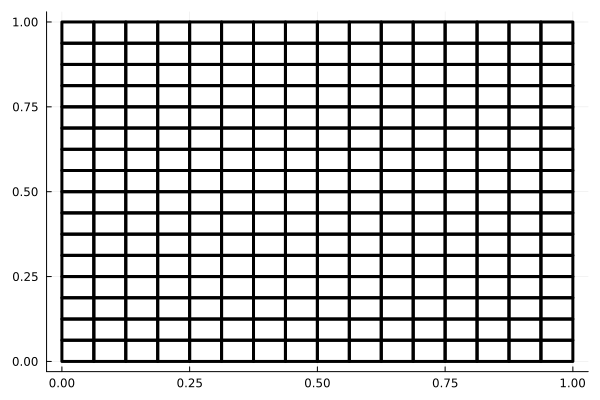

In [18]:
plotmesh(mesh, xc, yc, Ind.idx_x)

# <font color='blue'> Convergence study (Assembled)
 <font color='red'> It is slow, don't run it unless you need verification. See the solve time for the above mesh below for assmebled and matrix-free

In [19]:
@time GetFEMixed(kappa, mu, xc, yc, Ind, Bx, Bu, f, bc_idx, u_bc);

300.026718 seconds (435.10 k allocations: 385.339 GiB, 5.44% gc time)


In [20]:
@time nlsolve(u -> MixedElasticityResidual(kappa, mu, u, xc, yc, Ind, Bx, Bu, f, bc_idx, u_bc),
              u -> MixedElasticityJacobian(kappa, mu, u, xc, yc, Ind, Bx, Bu, f, bc_idx, u_bc), u0; method = :newton);

  2.302818 seconds (4.56 M allocations: 2.119 GiB, 7.36% gc time, 0.76% compilation time)


In [21]:
res = [4, 8, 12,16]
N = length(res)
eu = zeros(N)
ep = zeros(N)
order_u = []
append!(order_u, 0)
order_p = []
append!(order_p, 0)
H = zeros(N)
beta = zeros(N)
# refinement to plot convergence order
for i=1:N

    nx = res[i]
    ny = res[i]

    xc, yc = GetCoordMesh(mesh, nx, ny, aspect_ratio);
    Ind = FEIndices(P, Pp, num_comp, nx, ny, p_is_continuous, p_is_tensor);
    # Dirichlet BCs
    bc_idx = GetDirichletBCsIndex(Bu.num_comp, Ind);
    x = GetNodalCoordinate(xc, yc, Bu.Q, Ind);
    x_bc = x[bc_idx]
    x_bc = reshape(x_bc,:,2)
    u_bc = uex(x_bc[:,1], x_bc[:,2])
    
    Uh = GetFEMixed(kappa, mu, xc, yc, Ind, Bx, Bu, f, bc_idx, u_bc);
    L2_error_u, L2_error_p = GetL2Error(kappa, xc, yc, Ind, Bx, Bu, Uh, uex, pex)
    
    eu[i] = L2_error_u
    ep[i] = L2_error_p
    
    beta[i] = GetInfSup(xc, yc, Ind, Bx, Bu, "");
    
    #h = Gethsz(xc, yc, IEN)
    H[i] = 1/nx

    if (i > 1)
        logH = log10(H[i]/H[i-1])
        append!(order_u, log10(eu[i]/eu[i-1])/logH)
        append!(order_p, log10(ep[i]/ep[i-1])/logH)
    end
end

In [22]:
# P is number of nodes/elem in 1D for u, convergence order should be "P"
# Pp is number of nodes/elem in 1D for p, if pressure is tensor! otherwise is nodes/elem in 2D
df = DataFrame("N" => res, "Error u" => eu, "Order u" => order_u,"Error p" => ep, "Order p" => order_p, 
"Inf-sup constant" => beta)
println("***********************************************************************\n")
println("Convergence study (assembled) for 2D Mixed Elasticity for nu:$nu with $mesh mesh, number of nodes/elem u:$(P), p:$(Pp) \n")
println("Pressure field: (continuous, tensor)=($p_is_continuous, $p_is_tensor)\n")
println("***********************************************************************\n")
println(df)

***********************************************************************

Convergence study (assembled) for 2D Mixed Elasticity for nu:0.375 with uniform mesh, number of nodes/elem u:4, p:6 

Pressure field: (continuous, tensor)=(false, false)

***********************************************************************

4×6 DataFrame
 Row │ N      Error u     Order u  Error p      Order p  Inf-sup constant 
     │ Int64  Float64     Any      Float64      Any      Float64          
─────┼────────────────────────────────────────────────────────────────────
   1 │     4  2.41153e-5  0        0.00146568   0                0.858153
   2 │     8  1.59489e-6  3.91842  0.000194923  2.91059          0.821765
   3 │    12  3.19577e-7  3.96474  5.83409e-5   2.97511          0.813919
   4 │    16  1.01812e-7  3.97618  2.4688e-5    2.98936          0.81107


# Solve projection for P1 element defined on physical element

In [23]:
function GetMassLocal1(wdetJ, Bp)
    
    W2 = diagm(wdetJ);
    Me = Bp' * W2 * Bp
    return Me
end

function GetRhsLocal1(kappa, wdetJ, q, Q, f, Bp)
    
    W2 = diagm(wdetJ);
    xq = reshape(q, Q^2,:)
    Fe = Bp' * W2 * f(kappa, xq[:,1], xq[:,2])  # v^T * f
    return Fe
end

function elem_rest(idx_p)
    
    dof_p = maximum(idx_p)
       
    # element dof
    elem_dof_p = size(idx_p, 1)
    num_elem = size(idx_p, 2)
    Er_p = []
    for e = 1:num_elem
        Lp = zeros(Int64, elem_dof_p, dof_p)
        for i=1:elem_dof_p
            Lp[i, idx_p[i, e] ] = 1
        end
            
        push!(Er_p, Lp)
    end
    return Er_p
end

function GetFEProjection(kappa, xc, yc, Ind::FEIndices, Bx::FEBasis, idx_p, Er_p, f)
    
    num_elem = size(idx_p, 2)
    global_dof = maximum(idx_p)
    F = spzeros(global_dof, 1)
    M = spzeros(global_dof, global_dof)
    
    for e=1:num_elem
        # Get coordinate of each element
        Coord_E = GetCoordElem(xc, yc, Ind.Er_x, e);
        # Update quadrature
        q, wdetJ, _ = GetQdata(Coord_E, Bx);
        Bp = P1_basis_phy(q, Bx.Q)
        Me = GetMassLocal1(wdetJ, Bp);  # v^T * u
        Fe = GetRhsLocal1(kappa, wdetJ, q, Bx.Q, f, Bp);  # v^T * f

        # Assemble
        M = M + Er_p[e]' * Me * Er_p[e]
        F = F + Er_p[e]' * Fe

    end
    u = M \ F
    
   return u 
end

function GetL2Error1(kappa, xc, yc, Ind::FEIndices, Bx::FEBasis, idx_p, Er_p, ph, pex)
    """This function returns L2 error 
    (sum_{e=1:num_elem} (int_e (uh - uex)^2 dx) )^0.5 
    """

    num_elem = size(Ind.idx_u,2)

    e_p = zeros(num_elem)
    for e=1:num_elem
        # Get coordinate of each element
        Coord_E = GetCoordElem(xc, yc, Ind.Er_x, e);
        # Update quadrature
        q, wdetJ, _ = GetQdata(Coord_E, Bx);
        Bp = P1_basis_phy(q, Bx.Q)
        phh = Er_p[e] * ph
        p_num = Bp * phh
        
        xq = reshape(q, Q^2,:)
        p_ex = pex(kappa, xq[:,1], xq[:,2])

        err_p = vec((p_num - p_ex))
        # \int (u_num - u_ex)^2 dx ==> on element e
        e_p[e] = wdetJ' * (err_p .* err_p)

    end

    return sqrt(sum(e_p))
end

GetL2Error1 (generic function with 1 method)

In [24]:
# P is number of nodes in 1D, P=2 means Q1 element
# Pp is number of nodes in 1D if the pressure is tensor basis, otherwise is number of nodes in 2D
P, Pp, Qmode, p_is_continuous, p_is_tensor = 3, 3, "GAUSS", false, false
Q, num_comp = P, 2
Bx = FEBasis(2, Pp, Q, 2, Qmode, p_is_tensor);
nx, ny, mesh, aspect_ratio= 2,1, "uniform", 10
xc, yc = GetCoordMesh(mesh, nx, ny, aspect_ratio);
Ind = FEIndices(P, Pp, num_comp, nx, ny, p_is_continuous, p_is_tensor);
lambda, mu = 3, 1;
kappa = lambda + 2*mu/3;

idx_p = GetConnectivityPressure(3, nx, ny, false, false);
Er_p = elem_rest(idx_p)
ph = GetFEProjection(kappa, xc, yc, Ind, Bx, idx_p, Er_p, pex);
GetL2Error1(kappa, xc, yc, Ind, Bx, idx_p, Er_p, ph, pex);

res = [4, 8, 12, 16] # elements/side
N = length(res)
ep = zeros(N)
order_p = []
append!(order_p, 0)
H = zeros(N)
# refinement to plot convergence order
for i=1:N

    nx = res[i]
    ny = res[i]

    xc, yc = GetCoordMesh(mesh, nx, ny, aspect_ratio);
    Ind = FEIndices(P, Pp, num_comp, nx, ny, p_is_continuous, p_is_tensor);
    idx_p = GetConnectivityPressure(3, nx, ny, false, false);
    Er_p = elem_rest(idx_p)
    ph = GetFEProjection(kappa, xc, yc, Ind, Bx, idx_p, Er_p, pex);
    eee = GetL2Error1(kappa, xc, yc, Ind, Bx, idx_p, Er_p, ph, pex);
    
    ep[i] = eee
        
    #h = Gethsz(xc, yc, IEN)
    H[i] = 1/nx

    if (i > 1)
        logH = log10(H[i]/H[i-1])
        append!(order_p, log10(ep[i]/ep[i-1])/logH)
    end
end
order_p

4-element Vector{Any}:
 0
 1.962610547454403
 1.988186180140432
 1.994174649443653

# Inf-Sup results for discontinuous pressure and element aspect ratio 1

In [25]:
label_dis = ["Q1P0" "Q2P0" "Q2P1-ref" "Q2P1-phy" "Q3Q1" "Q3Q2" "Q4Q1" "Q4Q2"]
# Set: (u, p) for above elements
order_dis = [2 1; 3 1; 3 3;3 3; 4 2; 4 3; 5 2; 5 3]
p_is_tensors = [false; false; false; false; true; true; true; true]
mesh, aspect_ratio= "uniform", 1
num_comp, Qmode, p_is_continuous = 2, "GAUSS", false

res = 2:8
N = length(res)
H = zeros(N)
M = length(label_dis)
beta_dis_1 = zeros(N, M)

for j=1:M

    P, Pp, p_is_tensor = order_dis[j,1], order_dis[j,2], p_is_tensors[j,1]
    Q = P
    Bx = FEBasis(2, Pp, Q, 2, Qmode, p_is_tensor);
    Bu = FEBasis(P, Pp, Q, num_comp, Qmode, p_is_tensor);
    if j==4
        P1_config = "physical"
    else
        P1_config = ""
    end

    # refinement to plot convergence order
    for i=1:N

        nx = res[i]
        ny = res[i]

        xc, yc = GetCoordMesh(mesh, nx, ny, aspect_ratio);
        Ind = FEIndices(P, Pp, num_comp, nx, ny, p_is_continuous, p_is_tensor);
        beta_dis_1[i, j] = GetInfSup(xc, yc, Ind, Bx, Bu, P1_config);
    
        #h = Gethsz(xc, yc, IEN)
        H[i] = 1/nx

    end
end

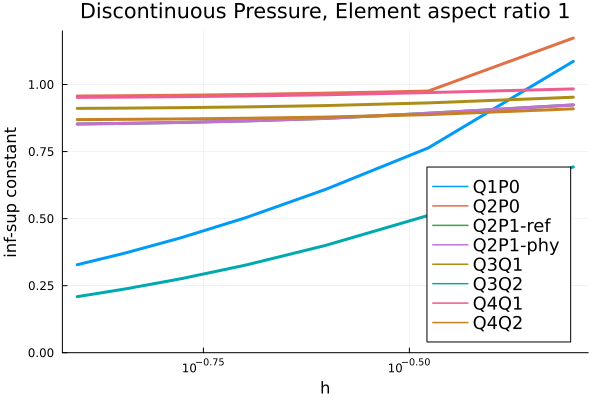

In [26]:
p = plot(title="Discontinuous Pressure, Element aspect ratio 1", xlabel="h", ylabel="inf-sup constant",
    legend=:bottomright, legend_font=12)
for j=1:M
    plot!(p, H, beta_dis_1[:,j], xaxis=:log, lw = 3,ylims=(0, 1.2), label = label_dis[j])
end
p

# Inf-Sup results for discontinuous pressure and element aspect ratio 10

In [27]:
label_dis = ["Q1P0" "Q2P0" "Q2P1-ref" "Q2P1-phy" "Q3Q1" "Q3Q2" "Q4Q1" "Q4Q2"]
# Set: (u, p) for above elements
order_dis = [2 1; 3 1; 3 3; 3 3; 4 2; 4 3; 5 2; 5 3]
p_is_tensors = [false; false; false; false; true; true; true; true]
mesh, aspect_ratio= "uniform", 10
num_comp, Qmode, p_is_continuous = 2, "GAUSS", false

res = 2:8
N = length(res)
H = zeros(N)
M = length(label_dis)
beta_dis_10 = zeros(N, M)

for j=1:M

    P, Pp, p_is_tensor = order_dis[j,1], order_dis[j,2], p_is_tensors[j,1]
    Q = P
    Bx = FEBasis(2, Pp, Q, 2, Qmode, p_is_tensor);
    Bu = FEBasis(P, Pp, Q, num_comp, Qmode, p_is_tensor);
    if j==4
        P1_config = "physical"
    else
        P1_config = ""
    end

    # refinement to plot convergence order
    for i=1:N

        nx = res[i]
        ny = res[i]

        xc, yc = GetCoordMesh(mesh, nx, ny, aspect_ratio);
        Ind = FEIndices(P, Pp, num_comp, nx, ny, p_is_continuous, p_is_tensor);
    
        beta_dis_10[i, j] = GetInfSup(xc, yc, Ind, Bx, Bu, P1_config)
    
        #h = Gethsz(xc, yc, IEN)
        H[i] = 1/nx

    end
end

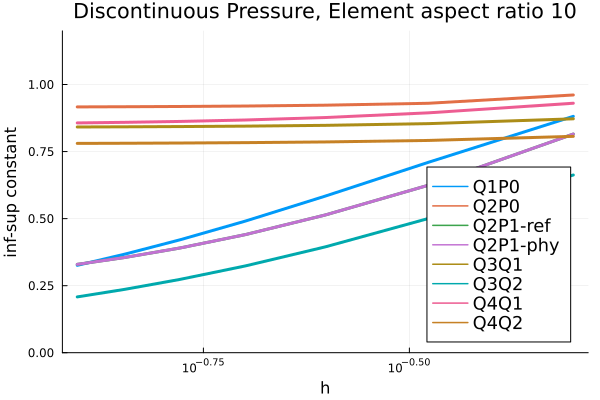

In [28]:
p = plot(title="Discontinuous Pressure, Element aspect ratio 10", xlabel="h", ylabel="inf-sup constant",
    legend=:bottomright, legend_font=12)
for j=1:M
    plot!(p, H, beta_dis_10[:,j], xaxis=:log, lw = 3,ylims=(0, 1.2), label = label_dis[j])
end
p

# Inf-Sup results for continuous pressure and element aspect ratio 1

In [29]:
label_cont = ["Q2Q1" "Q3Q1" "Q3Q2" "Q4Q1" "Q4Q2" "Q4Q3"]
order_cont = [3 2; 4 2; 4 3; 5 2; 5 3; 5 4]
mesh, aspect_ratio= "uniform", 1
num_comp, Qmode, p_is_continuous, p_is_tensor = 2, "GAUSS", true, true

res = 2:8
N = length(res)
H = zeros(N)
M = length(label_cont)
beta_cont_1 = zeros(N, M)

for j=1:M

P, Pp = order_cont[j,1], order_cont[j,2]
Q = P
Bx = FEBasis(2, Pp, Q, 2, Qmode, p_is_tensor);
Bu = FEBasis(P, Pp, Q, num_comp, Qmode, p_is_tensor);

    # refinement to plot convergence order
    for i=1:N

        nx = res[i]
        ny = res[i]

        xc, yc = GetCoordMesh(mesh, nx, ny, aspect_ratio);
        Ind = FEIndices(P, Pp, num_comp, nx, ny, p_is_continuous, p_is_tensor);
    
        beta_cont_1[i, j] = GetInfSup(xc, yc, Ind, Bx, Bu,"")
    
        #h = Gethsz(xc, yc, IEN)
        H[i] = 1/nx

    end
end

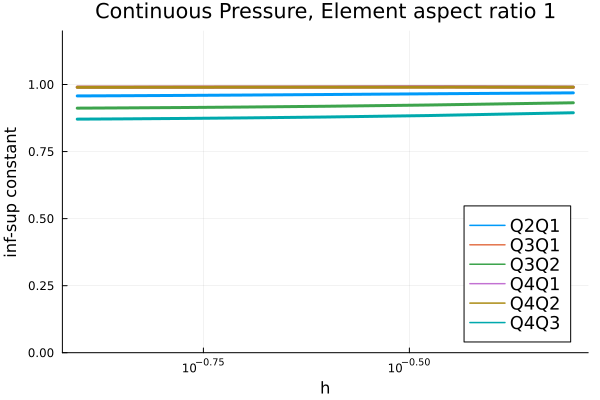

In [30]:
p = plot(title="Continuous Pressure, Element aspect ratio 1", xlabel="h", ylabel="inf-sup constant",
    legend=:bottomright, legend_font=12)
for j=1:M
    plot!(p, H, beta_cont_1[:,j], xaxis=:log, lw = 3,ylims=(0, 1.2), label = label_cont[j])
end
p

# Inf-Sup results for continuous pressure and element aspect ratio 10

In [ ]:
label_cont = ["Q2Q1" "Q3Q1" "Q3Q2" "Q4Q1" "Q4Q2" "Q4Q3"]
order_cont = [3 2; 4 2; 4 3; 5 2; 5 3; 5 4]
mesh, aspect_ratio= "uniform", 10
num_comp, Qmode, p_is_continuous, p_is_tensor = 2, "GAUSS", true, true

res = 2:8
N = length(res)
H = zeros(N)
M = length(label_cont)
beta_cont_10 = zeros(N, M)

for j=1:M

P, Pp = order_cont[j,1], order_cont[j,2]
Q = P
Bx = FEBasis(2, Pp, Q, 2, Qmode, p_is_tensor);
Bu = FEBasis(P, Pp, Q, num_comp, Qmode, p_is_tensor);

    # refinement to plot convergence order
    for i=1:N

        nx = res[i]
        ny = res[i]

        xc, yc = GetCoordMesh(mesh, nx, ny, aspect_ratio);
        Ind = FEIndices(P, Pp, num_comp, nx, ny, p_is_continuous, p_is_tensor);
    
        beta_cont_10[i, j] = GetInfSup(xc, yc, Ind, Bx, Bu, "")
    
        #h = Gethsz(xc, yc, IEN)
        H[i] = 1/nx

    end
end

In [ ]:
p = plot(title="Continuous Pressure, Element aspect ratio 10", xlabel="h", ylabel="inf-sup constant",
    legend=:bottomright, legend_font=12)
for j=1:M
    plot!(p, H, beta_cont_10[:,j], xaxis=:log, lw = 3,ylims=(0, 1.2), label = label_cont[j])
end
p